# Song popularity prediction based on audio features
* 8 audio features + nationality and artist scores, highest rank achieved and total days charting for each song.
* 4 classes for popularity (very high, high, mid, low)
* split 

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score, precision_recall_fscore_support

import graphviz

from datetime import date

%matplotlib inline
sns.set() # Setting seaborn as default style even if use only matplotlib

In [2]:
# constants
dataset_filename = 'Spotify_Dataset_V3_local.csv'
audio_features_col_names = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence']

In [3]:
spotify_filepath = os.path.join(os.getcwd(),'data', dataset_filename)
print(spotify_filepath)

spotify_data = pd.read_csv(spotify_filepath, delimiter=";")
spotify_data.head()

/Users/neo/Documents/1-app-ml/aml-code/AML-spotify/data/Spotify_Dataset_V3_local.csv


,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...


## data cleaning:
- Assume that 'Song URL' column is not needed
- all values are non-null, no need to remove rows
- should change "Date" column type to datetime
- sort dates via chronological order
- could rename columns (standard variable names)
- Scale the audio features
    - All features [0, 1]
    - Loudness : Log base 10 (of the absolute value) then divde by 60.

*TODO:*
- ~~verify all years full except 2023?~~
    --> total, use 2023

- **for different values (in the audio features) for the same song id:**
    - average
        - currently just taking the first one

In [4]:
spotify_data.columns

Index(['Rank', 'Title', 'Artists', 'Date', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', '# of Artist', 'Artist (Ind.)', '# of Nationality',
       'Nationality', 'Continent', 'Points (Total)',
       'Points (Ind for each Artist/Nat)', 'id', 'Song URL'],
      dtype='object')

In [5]:
# Assume that 'Song URL' column is not needed
spotify_data.drop(['Song URL'], axis=1, inplace=True, errors='ignore')

# Rename columns
spotify_data = spotify_data.rename(columns={
    "# of Artist": "Num_of_artist", "Artist (Ind.)": "Artist_ind", "# of Nationality": "Num_of_nationality", 
    "Points (Total)": "Points_total", "Points (Ind for each Artist/Nat)": "Points_ind", "Song URL": "Song_URL"
})

In [6]:
# make "Date" column datetime type
spotify_data["Date"] = pd.to_datetime(spotify_data["Date"], dayfirst=True)
spotify_data.info()
# spotify_data.loc[0]["Date"]

# reverse dates
spotify_data = spotify_data.sort_values(by="Date")
# spotify_data.head()

# Keep in mind, ranks are also reversed now...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Rank                651936 non-null  int64         
 1   Title               651936 non-null  object        
 2   Artists             651936 non-null  object        
 3   Date                651936 non-null  datetime64[ns]
 4   Danceability        651936 non-null  float64       
 5   Energy              651936 non-null  float64       
 6   Loudness            651936 non-null  float64       
 7   Speechiness         651936 non-null  float64       
 8   Acousticness        651936 non-null  float64       
 9   Instrumentalness    651936 non-null  float64       
 10  Valence             651936 non-null  float64       
 11  Num_of_artist       651936 non-null  object        
 12  Artist_ind          651936 non-null  object        
 13  Num_of_nationality  651936 no

In [7]:
spotify_data.describe()

,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points_total,Points_ind
count,651936.000000,651936,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000
mean,100.407782,2020-03-26 22:03:35.226034688,0.697730,0.652049,-5295.645217,0.109946,0.230694,0.007647,0.523134,100.592218,72.391141
min,1.000000,2017-01-01 00:00:00,0.073000,0.005000,-34475.000000,0.022000,0.000000,0.000000,0.026000,1.000000,0.200000
25%,51.000000,2018-08-23 00:00:00,0.617000,0.549000,-6825.000000,0.045000,0.048000,0.000000,0.356000,51.000000,28.000000
50%,100.000000,2020-03-16 00:00:00,0.719000,0.671000,-5206.000000,0.068000,0.152000,0.000000,0.521000,101.000000,60.000000
75%,150.000000,2021-11-16 00:00:00,0.793000,0.771000,-3885.000000,0.136000,0.349000,0.000000,0.696000,150.000000,104.000000
max,200.000000,2023-05-29 00:00:00,0.985000,0.996000,1509.000000,0.966000,0.994000,0.956000,0.982000,200.000000,200.000000
std,57.406664,NaN,0.133186,0.155684,2785.261321,0.096841,0.230710,0.054724,0.223926,57.406664,54.227892


In [8]:
# Scale the audio features.
# spotify_data['Loudness'] = spotify_data['Loudness'].apply(lambda x: np.log10(np.abs(x)) / 60)
spotify_data['Loudness']=(spotify_data['Loudness']-spotify_data['Loudness'].mean())/spotify_data['Loudness'].std()
spotify_data.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id
651935,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,-0.297766,0.248,0.076,0.0,0.684,Artist 2,Kanye West,Nationality 2,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O
651770,62,Sexual,"NEIKED, Dyo",2017-01-01,0.803,0.569,-0.752660,0.074,0.062,0.0,0.809,Artist 1,NEIKED,Nationality 1,Sweden,Europe,139,70.0,3AsAuGTaDQzavZZThyYlop
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,-1.545763,0.370,0.157,0.0,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.0,5hYTyyh2odQKphUbMqc5gN
651768,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,-0.900941,0.117,0.057,0.0,0.392,Artist 2,Rihanna,Nationality 2,Barbados,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,-0.900941,0.117,0.057,0.0,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew


## Prepare for classification
Ideas:
* first split into "popular" vs "unpopular"
* then try "hit", "high", "mid", "low"
* then see whether other features such as cumulative days charting, release date, genre etc. can be used as well...?

In [9]:
# want one row per song.
dropped_artist_split = spotify_data.drop_duplicates(subset=['Title', 'Artists', 'Date'], keep="last") 
# TODO: should really keep the first listed artist.

grouped_by_title = dropped_artist_split.groupby(["Title", "Artists"])
grouped_by_title.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,-1.545763,0.370,0.157,0.0,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.0,5hYTyyh2odQKphUbMqc5gN
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,-0.900941,0.117,0.057,0.0,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew
651766,59,Panda,Desiigner,2017-01-01,0.576,0.766,0.126611,0.449,0.028,0.0,0.236,Artist 1,Desiigner,Nationality 1,United States,Anglo-America,142,142.0,5OOkp4U9P9oL23maHFHL1h
651764,58,Perfect Strangers,"Jos Blue, JP Cooper",2017-01-01,0.739,0.833,0.101838,0.046,0.350,0.0,0.699,Artist 1,Jos Blue,Nationality 1,United States,Anglo-America,143,72.0,5bZtRlMBU76vHuDOb1GM5u
651762,57,La Bicicleta,"Carlos Vives, Shakira",2017-01-01,0.736,0.964,1.130467,0.129,0.198,0.0,0.953,Artist 1,Carlos Vives,Nationality 1,Colombia,Latin-America,144,72.0,0sXvAOmXgjR2QUqLK1MltU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,85,Bye,Peso Pluma,2023-05-29,0.782,0.812,-0.472973,0.047,0.567,0.0,0.700,Artist 1,Peso Pluma,Nationality 1,Mexico,Latin-America,116,116.0,6n2P81rPk2RTzwnNNgFOdb
57,37,Dance The Night (From Barbie The Album),Dua Lipa,2023-05-29,0.671,0.845,1.899540,0.048,0.021,0.0,0.775,Artist 1,Dua Lipa,Nationality 1,United Kingdom,Europe,164,164.0,1vYXt7VSjH9JIM5oRRo7vA
52,33,Hits Different,Taylor Swift,2023-05-29,0.672,0.782,-0.432044,0.042,0.148,0.0,0.239,Artist 1,Taylor Swift,Nationality 1,United States,Anglo-America,168,168.0,3xYJScVfxByb61dYHTwiby
284,194,Car's Outside,James Arthur,2023-05-29,0.338,0.562,-0.676904,0.029,0.039,0.0,0.259,Artist 1,James Arthur,Nationality 1,United Kingdom,Europe,7,7.0,0otRX6Z89qKkHkQ9OqJpKt


In [10]:
summed_points = grouped_by_title["Points_total"].sum()

In [11]:
# add on the total points to the right
grouped_df = grouped_by_title.first()

In [12]:
one_row_one_song = grouped_df.merge(summed_points.rename("Points_sum"), left_index=True, right_index=True)
# one_row_one_song.drop(['Num_of_nationality', "Nationality", "Continent", "Points_total", "Points_ind", "Num_of_artist", "Artist_ind"], axis=1, inplace=True, errors='ignore')
one_row_one_song

,,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id,Points_sum
Title,Artists,,,,,,,,,,,,,,,,,,
'98 Braves,Morgan Wallen,72,2023-03-03,0.488,0.670,-0.166360,0.027,0.097,0.0,0.484,Artist 1,Morgan Wallen,Nationality 1,United States,Anglo-America,129,129.0,3oZ6dlSfCE9gZ55MGPJctc,287
!,Trippie Redd,56,2019-08-09,0.725,0.543,-0.364546,0.084,0.030,0.0,0.693,Artist 1,Trippie Redd,Nationality 1,United States,Anglo-America,145,145.0,5a1ofLoPiAn5xxf5UE6472,194
#PROUDCATOWNERREMIX,"XXXTENTACION, Rico Nasty",189,2019-08-23,0.783,0.522,-0.335105,0.390,0.029,0.0,0.235,Artist 2,Rico Nasty,Nationality 2,United States,Anglo-America,12,6.0,5dkZ2DrcPJrqwlRQe6Q35e,12
$$$,XXXTENTACION,67,2018-03-16,0.774,0.507,-0.594686,0.065,0.064,0.0,0.508,Artist 1,XXXTENTACION,Nationality 1,United States,Anglo-America,134,134.0,65u1dHQyQyE4y4aN2eDmMF,1018
$€ Freestyle,Sfera Ebbasta,76,2020-11-20,0.813,0.670,-1.208273,0.335,0.200,0.0,0.380,Artist 1,Sfera Ebbasta,Nationality 1,Italy,Europe,125,125.0,2j9wr1cxfYcMJoANfmoJA9,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,Damso,166,2021-04-29,0.416,0.528,-1.813961,0.291,0.178,0.0,0.203,Artist 1,Damso,Nationality 1,Belgium,Europe,35,35.0,5UNFWkGaEJgQFqoJxZWMzm,35
ÎŸ. OG,Damso,84,2021-04-29,0.576,0.446,-1.725998,0.044,0.773,0.4,0.060,Artist 1,Damso,Nationality 1,Belgium,Europe,117,117.0,63ALxy05IGeKrfOjvGG7lO,117
İmdat,cakal,153,2022-04-18,0.786,0.748,-0.815850,0.162,0.267,0.0,0.562,Artist 1,cakal,Nationality 1,Turkey,Europe,48,48.0,123hB20IVD2yw1NMIgrqb3,1161


In [13]:
one_row_one_song.describe()

,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points_total,Points_ind,Points_sum
count,7801.000000,7801,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,112.810281,2020-01-14 04:33:22.820151552,0.674761,0.635774,-0.195459,0.131297,0.236030,0.014046,0.487988,88.189719,76.877140,6048.995257
min,1.000000,2017-01-01 00:00:00,0.073000,0.005000,-10.476344,0.022000,0.000000,0.000000,0.026000,1.000000,0.200000,1.000000
25%,58.000000,2018-06-29 00:00:00,0.582000,0.530000,-0.770253,0.045000,0.041000,0.000000,0.312000,29.000000,22.000000,90.000000
50%,120.000000,2020-01-24 00:00:00,0.692000,0.652000,-0.165282,0.078000,0.141000,0.000000,0.485000,81.000000,64.000000,588.000000
75%,172.000000,2021-07-23 00:00:00,0.785000,0.761000,0.395527,0.187000,0.355000,0.000000,0.662000,143.000000,126.000000,3994.000000
max,200.000000,2023-05-28 00:00:00,0.985000,0.996000,2.443090,0.966000,0.994000,0.956000,0.982000,200.000000,200.000000,244737.000000
std,62.625322,NaN,0.148632,0.172027,1.139103,0.120088,0.249934,0.083675,0.226476,62.625322,60.833552,15416.891904


In [14]:
# sort by points sum
one_row_one_song.sort_values(by="Points_sum", ascending=False, inplace=True)

# create popularity column and top half is "popular", bottom half is "unpopular"
one_row_one_song["Popularity"] = "n/a"
# l = len(one_row_one_song.index) // 2 
# one_row_one_song.iloc[:l, -1] = 'popular'
# one_row_one_song.iloc[l:, -1] = 'unpopular'

# create binary popularity column and top half is "popular", bottom half is "unpopular"
one_row_one_song["Popularity_class"] = -2
# l = len(one_row_one_song.index) // 2 
# one_row_one_song.iloc[:l, -1] = 1
# one_row_one_song.iloc[l:, -1] = 0
# one_row_one_song

# one_row_one_song["Binary_popularity"] = [ 1 if i>=one_row_one_song["Points_sum"].mean() else 0 for i in one_row_one_song.Points_sum ]
# one_row_one_song["Binary_popularity"] = [ 1 if i>=1500 else 0 for i in one_row_one_song.Points_sum ]

q = len(one_row_one_song.index) // 4
one_row_one_song.iloc[:q, -1] = 0
one_row_one_song.iloc[q:(q*2), -1] = 1
one_row_one_song.iloc[(q*2):(q*3), -1] = 2
one_row_one_song.iloc[(q*3):, -1] = 3

r = one_row_one_song["Points_sum"].max() // 4
print(r)
class_boundaries = []
# one_row_one_song.loc[one_row_one_song['Points_sum'] <= r, 'Popularity_class'] = 0
# one_row_one_song.loc[((one_row_one_song['Points_sum'] <= 2*r) & (one_row_one_song['Points_sum'] > r)), 'Popularity_class'] = 1
# one_row_one_song.loc[((one_row_one_song['Points_sum'] <= 3*r) & (one_row_one_song['Points_sum'] > 2*r)), 'Popularity_class'] = 2
# one_row_one_song.loc[one_row_one_song['Points_sum'] > 3*r, 'Popularity_class'] = 3

one_row_one_song["Popularity_class"].value_counts()
# one_row_one_song

61184


Popularity_class
3    1951
0    1950
1    1950
2    1950
Name: count, dtype: int64

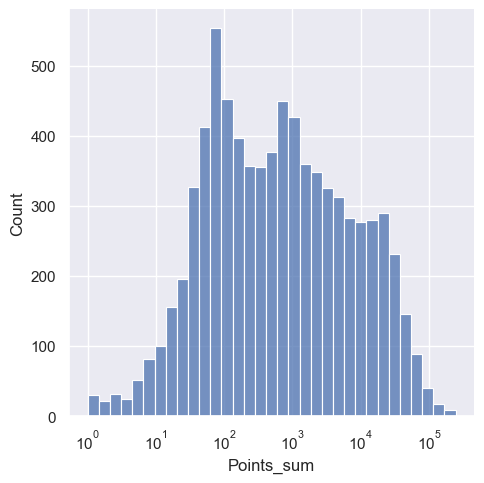

In [15]:
# get drstribution of points
sns.displot(data=one_row_one_song, x="Points_sum", log_scale=10)

## Adding more features
* artist popularity
* highest rank achieved
* longest streak charting / cumulative days charting
* nationality score.
* \# of artists on track

In [16]:
one_row_one_song_copy = one_row_one_song.copy(deep=True)
excel_data_filepath = os.path.join(os.getcwd(),'data', 'S_Spotify_Dataset_Songs.csv')
print(excel_data_filepath)

excel_data = pd.read_csv(excel_data_filepath, delimiter=",")
excel_data.drop(audio_features_col_names, axis=1, inplace=True)
excel_data

/Users/neo/Documents/1-app-ml/aml-code/AML-spotify/data/S_Spotify_Dataset_Songs.csv


,Column1,Title,Artists,Published_date,Hot_date,Total_Popularity
0,778,White Christmas,"Bing Crosby, Ken Darby Singers, John Scott Tro...",1942-01-01,2017-11-26,20909
1,4866,It's Beginning To Look Like Christmas,Bing Crosby,1945-01-01,2018-12-24,462
2,4867,Mele Kalikimaka (Merry Christmas),"Bing Crosby, The Andrews Sisters",1945-01-01,2018-12-24,311
3,803,God Rest Ye Merry Gentlemen,Bing Crosby,1945-01-01,2021-12-24,102
4,2028,God Rest Ye Merry Gentlemen,Bing Crosby,1945-01-01,2021-12-24,102
...,...,...,...,...,...,...
8687,64,Karma (feat. Ice Spice),"Taylor Swift, Ice Spice",2023-05-26,2023-05-26,646
8688,84,Bye,Peso Pluma,2023-05-26,2023-05-26,368
8689,213,War Bout It (feat. 21 Savage),"Lil Durk, 21 Savage",2023-05-26,2023-05-26,123
8690,222,Pelle Coat,Lil Durk,2023-05-26,2023-05-26,29


In [17]:
one_row_one_song_copy = one_row_one_song_copy.reset_index()
one_row_one_song_copy

,Title,Artists,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id,Points_sum,Popularity,Popularity_class
0,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.355674,0.108,0.052,0.0,...,Imagine Dragons,Nationality 1,United States,Anglo-America,36,36.0,0CcQNd8CINkwQfe1RDtGV6,244737,n/a,0
1,Shape of You,Ed Sheeran,1,2017-01-06,0.825,0.652,0.758509,0.080,0.581,0.0,...,Ed Sheeran,Nationality 1,United Kingdom,Europe,200,200.0,7qiZfU4dY1lWllzX7mPBI3,227794,n/a,0
2,Blinding Lights,The Weeknd,8,2019-11-29,0.513,0.796,0.438252,0.063,0.001,0.0,...,The Weeknd,Nationality 1,Canada,Anglo-America,193,193.0,0sf12qNH5qcw8qpgymFOqD,220508,n/a,0
3,Someone You Loved,Lewis Capaldi,198,2019-01-07,0.501,0.405,-0.137637,0.032,0.751,0.0,...,Lewis Capaldi,Nationality 1,United Kingdom,Europe,3,3.0,2TIlqbIneP0ZY1O0EzYLlc,220157,n/a,0
4,Perfect,Ed Sheeran,10,2017-03-03,0.599,0.448,-0.364905,0.023,0.163,0.0,...,Ed Sheeran,Nationality 1,United Kingdom,Europe,191,191.0,0tgVpDi06FyKpA1z0VMD4v,200148,n/a,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,Maps,Maroon 5,200,2023-04-13,0.742,0.713,-0.081269,0.030,0.021,0.0,...,Maroon 5,Nationality 1,United States,Anglo-America,1,1.0,4gbVRS8gloEluzf0GzDOFc,1,n/a,3
7797,Hood,"AK AUSSERKONTROLLE, Shindy",200,2020-03-27,0.874,0.435,1.898190,0.402,0.027,0.0,...,AK AUSSERKONTROLLE,Nationality 1,Germany,Europe,1,1.0,6xMBPfgaEQKshwp7oYrtP4,1,n/a,3
7798,DrIP DrIp Drip (feat. Meek Mill),Tory Lanez,200,2018-10-19,0.710,0.814,0.258735,0.056,0.162,0.0,...,Tory Lanez,Nationality 1,Canada,Anglo-America,1,1.0,39Bq9cOTO0H8M6P9iKLVdq,1,n/a,3
7799,Under Pressure,"Shawn Mendes, Teddy Geiger",200,2018-10-12,0.667,0.478,-0.017720,0.032,0.200,0.0,...,Teddy Geiger,Nationality 2,United States,Anglo-America,1,1.0,2fLyikLZmHxW4XdToFpDdN,1,n/a,3


In [18]:
# pd.concat([df1, df4], axis=1)
spotify_plus = pd.merge(one_row_one_song_copy, excel_data[["Title", "Artists", "Published_date", "Hot_date"]], how="left", on=["Title", "Artists"])
spotify_plus = spotify_plus.drop_duplicates(subset=['Title', 'Artists', 'Date'], keep="last") 
spotify_plus

,Title,Artists,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Nationality,Continent,Points_total,Points_ind,id,Points_sum,Popularity,Popularity_class,Published_date,Hot_date
5,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.355674,0.108,0.052,0.0,...,United States,Anglo-America,36,36.0,0CcQNd8CINkwQfe1RDtGV6,244737,n/a,0,2017-06-23,2017-02-02
6,Shape of You,Ed Sheeran,1,2017-01-06,0.825,0.652,0.758509,0.080,0.581,0.0,...,United Kingdom,Europe,200,200.0,7qiZfU4dY1lWllzX7mPBI3,227794,n/a,0,2017-03-03,2017-01-06
9,Blinding Lights,The Weeknd,8,2019-11-29,0.513,0.796,0.438252,0.063,0.001,0.0,...,Canada,Anglo-America,193,193.0,0sf12qNH5qcw8qpgymFOqD,220508,n/a,0,2020-03-20,2019-11-29
10,Someone You Loved,Lewis Capaldi,198,2019-01-07,0.501,0.405,-0.137637,0.032,0.751,0.0,...,United Kingdom,Europe,3,3.0,2TIlqbIneP0ZY1O0EzYLlc,220157,n/a,0,2019-05-17,2019-01-07
11,Perfect,Ed Sheeran,10,2017-03-03,0.599,0.448,-0.364905,0.023,0.163,0.0,...,United Kingdom,Europe,191,191.0,0tgVpDi06FyKpA1z0VMD4v,200148,n/a,0,2017-03-03,2017-03-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Maps,Maroon 5,200,2023-04-13,0.742,0.713,-0.081269,0.030,0.021,0.0,...,United States,Anglo-America,1,1.0,4gbVRS8gloEluzf0GzDOFc,1,n/a,3,2014-09-02,2023-04-13
8689,Hood,"AK AUSSERKONTROLLE, Shindy",200,2020-03-27,0.874,0.435,1.898190,0.402,0.027,0.0,...,Germany,Europe,1,1.0,6xMBPfgaEQKshwp7oYrtP4,1,n/a,3,2020-03-27,2020-03-27
8690,DrIP DrIp Drip (feat. Meek Mill),Tory Lanez,200,2018-10-19,0.710,0.814,0.258735,0.056,0.162,0.0,...,Canada,Anglo-America,1,1.0,39Bq9cOTO0H8M6P9iKLVdq,1,n/a,3,2018-10-19,2018-10-19
8691,Under Pressure,"Shawn Mendes, Teddy Geiger",200,2018-10-12,0.667,0.478,-0.017720,0.032,0.200,0.0,...,United States,Anglo-America,1,1.0,2fLyikLZmHxW4XdToFpDdN,1,n/a,3,2018-09-25,2018-10-12


### artist popularity score

In [19]:
# artist popularity score
grouped_by_artist = spotify_data.groupby("Artists")
# grouped_by_artist.head()
artists_popularity = grouped_by_artist['Points_total'].size().sort_values(ascending=False)
artists_popularity

Artists
Ed Sheeran           12289
Post Malone           7724
XXXTENTACION          6924
Billie Eilish         6756
Bad Bunny             5756
                     ...  
The Beatles              1
Benjamin Ingrosso        1
M.I.A.                   1
Thalia                   1
Gala                     1
Name: Points_total, Length: 2928, dtype: int64

In [20]:
spotify_plus = spotify_plus.merge(artists_popularity, on=['Artists'], how = 'left')
spotify_plus.rename(columns={"Points_total_y": "Artist_score"}, inplace=True)

# assign_artist_popularity(artists_popularity)

spotify_plus

,Title,Artists,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Continent,Points_total_x,Points_ind,id,Points_sum,Popularity,Popularity_class,Published_date,Hot_date,Artist_score
0,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.355674,0.108,0.052,0.0,...,Anglo-America,36,36.0,0CcQNd8CINkwQfe1RDtGV6,244737,n/a,0,2017-06-23,2017-02-02,5228
1,Shape of You,Ed Sheeran,1,2017-01-06,0.825,0.652,0.758509,0.080,0.581,0.0,...,Europe,200,200.0,7qiZfU4dY1lWllzX7mPBI3,227794,n/a,0,2017-03-03,2017-01-06,12289
2,Blinding Lights,The Weeknd,8,2019-11-29,0.513,0.796,0.438252,0.063,0.001,0.0,...,Anglo-America,193,193.0,0sf12qNH5qcw8qpgymFOqD,220508,n/a,0,2020-03-20,2019-11-29,5698
3,Someone You Loved,Lewis Capaldi,198,2019-01-07,0.501,0.405,-0.137637,0.032,0.751,0.0,...,Europe,3,3.0,2TIlqbIneP0ZY1O0EzYLlc,220157,n/a,0,2019-05-17,2019-01-07,2985
4,Perfect,Ed Sheeran,10,2017-03-03,0.599,0.448,-0.364905,0.023,0.163,0.0,...,Europe,191,191.0,0tgVpDi06FyKpA1z0VMD4v,200148,n/a,0,2017-03-03,2017-03-03,12289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,Maps,Maroon 5,200,2023-04-13,0.742,0.713,-0.081269,0.030,0.021,0.0,...,Anglo-America,1,1.0,4gbVRS8gloEluzf0GzDOFc,1,n/a,3,2014-09-02,2023-04-13,2494
7797,Hood,"AK AUSSERKONTROLLE, Shindy",200,2020-03-27,0.874,0.435,1.898190,0.402,0.027,0.0,...,Europe,1,1.0,6xMBPfgaEQKshwp7oYrtP4,1,n/a,3,2020-03-27,2020-03-27,2
7798,DrIP DrIp Drip (feat. Meek Mill),Tory Lanez,200,2018-10-19,0.710,0.814,0.258735,0.056,0.162,0.0,...,Anglo-America,1,1.0,39Bq9cOTO0H8M6P9iKLVdq,1,n/a,3,2018-10-19,2018-10-19,323
7799,Under Pressure,"Shawn Mendes, Teddy Geiger",200,2018-10-12,0.667,0.478,-0.017720,0.032,0.200,0.0,...,Anglo-America,1,1.0,2fLyikLZmHxW4XdToFpDdN,1,n/a,3,2018-09-25,2018-10-12,2


### highest rank achieved

In [21]:
# highest rank achieved
max_rank = grouped_by_artist["Rank"].max()
max_rank.sort_values(ascending=False)

Artists
Manu Gavassi, Gloria Groove                                      200
Little Mix                                                       200
Linkin Park                                                      200
ThxSoMch                                                         200
Daddy Yankee, Sech                                               200
                                                                ... 
Drake, Michael Jackson                                            10
DJ Snake, J Balvin, Tyga                                          10
Logic, Eminem                                                      5
Grupo Frontera, Bad Bunny                                          5
DJ Khaled, Justin Bieber, Quavo, Chance the Rapper, Lil Wayne      2
Name: Rank, Length: 2928, dtype: int64

In [22]:
spotify_plus = spotify_plus.merge(max_rank, on=['Artists'], how = 'left')
spotify_plus.rename(columns={"Rank_y": "Highest_rank"}, inplace=True)

spotify_plus

,Title,Artists,Rank_x,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Points_total_x,Points_ind,id,Points_sum,Popularity,Popularity_class,Published_date,Hot_date,Artist_score,Highest_rank
0,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.355674,0.108,0.052,0.0,...,36,36.0,0CcQNd8CINkwQfe1RDtGV6,244737,n/a,0,2017-06-23,2017-02-02,5228,200
1,Shape of You,Ed Sheeran,1,2017-01-06,0.825,0.652,0.758509,0.080,0.581,0.0,...,200,200.0,7qiZfU4dY1lWllzX7mPBI3,227794,n/a,0,2017-03-03,2017-01-06,12289,200
2,Blinding Lights,The Weeknd,8,2019-11-29,0.513,0.796,0.438252,0.063,0.001,0.0,...,193,193.0,0sf12qNH5qcw8qpgymFOqD,220508,n/a,0,2020-03-20,2019-11-29,5698,200
3,Someone You Loved,Lewis Capaldi,198,2019-01-07,0.501,0.405,-0.137637,0.032,0.751,0.0,...,3,3.0,2TIlqbIneP0ZY1O0EzYLlc,220157,n/a,0,2019-05-17,2019-01-07,2985,200
4,Perfect,Ed Sheeran,10,2017-03-03,0.599,0.448,-0.364905,0.023,0.163,0.0,...,191,191.0,0tgVpDi06FyKpA1z0VMD4v,200148,n/a,0,2017-03-03,2017-03-03,12289,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,Maps,Maroon 5,200,2023-04-13,0.742,0.713,-0.081269,0.030,0.021,0.0,...,1,1.0,4gbVRS8gloEluzf0GzDOFc,1,n/a,3,2014-09-02,2023-04-13,2494,200
7797,Hood,"AK AUSSERKONTROLLE, Shindy",200,2020-03-27,0.874,0.435,1.898190,0.402,0.027,0.0,...,1,1.0,6xMBPfgaEQKshwp7oYrtP4,1,n/a,3,2020-03-27,2020-03-27,2,200
7798,DrIP DrIp Drip (feat. Meek Mill),Tory Lanez,200,2018-10-19,0.710,0.814,0.258735,0.056,0.162,0.0,...,1,1.0,39Bq9cOTO0H8M6P9iKLVdq,1,n/a,3,2018-10-19,2018-10-19,323,200
7799,Under Pressure,"Shawn Mendes, Teddy Geiger",200,2018-10-12,0.667,0.478,-0.017720,0.032,0.200,0.0,...,1,1.0,2fLyikLZmHxW4XdToFpDdN,1,n/a,3,2018-09-25,2018-10-12,2,200


### days charting

In [23]:
# days charting
# days_charting = grouped_by_title.size().rename("Days_charting")
# days_charting.sort_values(ascending=False)

In [ ]:
# spotify_plus = spotify_plus.merge(days_charting, on=['Title', 'Artists'], how = 'left')
# # spotify_plus.rename(columns={"Rank_y": "Highest_rank"}, inplace=True)

# spotify_plus

NameError: name 'days_charting' is not defined

### nationality popularity

In [25]:
# nationality popularity

# nationality = grouped_by_title.size().rename("Days_charting")
# days_charting.sort_values(ascending=False)
print(spotify_data["Nationality"].unique())
print(len(spotify_data["Nationality"].unique()))

grouped_nationality = spotify_data.groupby("Nationality")
nationality_points = grouped_nationality["Nationality"].size().rename("Nationality_score")
nationality_points.sort_values(ascending=False)

['United States' 'Sweden' 'Canada' 'Barbados' 'United Kingdom' 'Colombia'
 'France' 'Germany' 'Brazil' 'Puerto Rico' 'Norway' 'Denmark' 'Australia'
 'Spain' 'Netherlands' 'Philippines' 'Nigeria' 'Russia' 'Cuba' 'Mexico'
 'Jamaica' 'Austria' 'Venezuela' 'South Korea' 'Ireland' 'Albania' 'Japan'
 'Iceland' 'Turkey' 'New Zealand' 'Suecia' 'South Africa' 'Morocco'
 'Moldavia' 'Portugal' 'Belgium' 'Dominican Republic' 'Ecuador' 'Finland'
 'Italy' 'Ukraine' 'Indonesia' 'Argentina' 'Israel' 'Unknown' 'Greece'
 'Czech Republic' 'Lithuania' 'Costa Rica' 'Kosovo' 'Romania' 'Panama'
 'Chili' 'Swiss' 'Cameroon' 'Bonaire' 'Senegal' 'Republic of Congo'
 'Kazakhstan' 'China' 'Lebanon' 'Scotland' 'Malta' 'Azerbaijan'
 'Solomon Islands' 'Poland' 'India' 'Thailand' 'Ghana' 'Haiti' 'Pakistan'
 'Ivory Coast' 'ALGERIA' 'Sri Lanka']
74


Nationality
United States     274804
United Kingdom     84336
Puerto Rico        76600
Canada             39602
Colombia           34889
                   ...  
Bonaire                1
Senegal                1
Azerbaijan             1
Malta                  1
Lebanon                1
Name: Nationality_score, Length: 74, dtype: int64

In [26]:
spotify_plus = spotify_plus.merge(nationality_points, on=['Nationality'], how = 'left')
# spotify_plus.rename(columns={"Rank_y": "Highest_rank"}, inplace=True)

spotify_plus

,Title,Artists,Rank_x,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Points_ind,id,Points_sum,Popularity,Popularity_class,Published_date,Hot_date,Artist_score,Highest_rank,Nationality_score
0,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.355674,0.108,0.052,0.0,...,36.0,0CcQNd8CINkwQfe1RDtGV6,244737,n/a,0,2017-06-23,2017-02-02,5228,200,274804
1,Shape of You,Ed Sheeran,1,2017-01-06,0.825,0.652,0.758509,0.080,0.581,0.0,...,200.0,7qiZfU4dY1lWllzX7mPBI3,227794,n/a,0,2017-03-03,2017-01-06,12289,200,84336
2,Blinding Lights,The Weeknd,8,2019-11-29,0.513,0.796,0.438252,0.063,0.001,0.0,...,193.0,0sf12qNH5qcw8qpgymFOqD,220508,n/a,0,2020-03-20,2019-11-29,5698,200,39602
3,Someone You Loved,Lewis Capaldi,198,2019-01-07,0.501,0.405,-0.137637,0.032,0.751,0.0,...,3.0,2TIlqbIneP0ZY1O0EzYLlc,220157,n/a,0,2019-05-17,2019-01-07,2985,200,84336
4,Perfect,Ed Sheeran,10,2017-03-03,0.599,0.448,-0.364905,0.023,0.163,0.0,...,191.0,0tgVpDi06FyKpA1z0VMD4v,200148,n/a,0,2017-03-03,2017-03-03,12289,200,84336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,Maps,Maroon 5,200,2023-04-13,0.742,0.713,-0.081269,0.030,0.021,0.0,...,1.0,4gbVRS8gloEluzf0GzDOFc,1,n/a,3,2014-09-02,2023-04-13,2494,200,274804
7797,Hood,"AK AUSSERKONTROLLE, Shindy",200,2020-03-27,0.874,0.435,1.898190,0.402,0.027,0.0,...,1.0,6xMBPfgaEQKshwp7oYrtP4,1,n/a,3,2020-03-27,2020-03-27,2,200,8388
7798,DrIP DrIp Drip (feat. Meek Mill),Tory Lanez,200,2018-10-19,0.710,0.814,0.258735,0.056,0.162,0.0,...,1.0,39Bq9cOTO0H8M6P9iKLVdq,1,n/a,3,2018-10-19,2018-10-19,323,200,39602
7799,Under Pressure,"Shawn Mendes, Teddy Geiger",200,2018-10-12,0.667,0.478,-0.017720,0.032,0.200,0.0,...,1.0,2fLyikLZmHxW4XdToFpDdN,1,n/a,3,2018-09-25,2018-10-12,2,200,274804


In [27]:
# any null values?
spotify_plus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801 entries, 0 to 7800
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Title               7801 non-null   object        
 1   Artists             7801 non-null   object        
 2   Rank_x              7801 non-null   int64         
 3   Date                7801 non-null   datetime64[ns]
 4   Danceability        7801 non-null   float64       
 5   Energy              7801 non-null   float64       
 6   Loudness            7801 non-null   float64       
 7   Speechiness         7801 non-null   float64       
 8   Acousticness        7801 non-null   float64       
 9   Instrumentalness    7801 non-null   float64       
 10  Valence             7801 non-null   float64       
 11  Num_of_artist       7801 non-null   object        
 12  Artist_ind          7801 non-null   object        
 13  Num_of_nationality  7801 non-null   object      

## Naive Bayes

In [71]:
# only features and labels...
nb_df = spotify_plus.copy(deep=True)

# Student needs to provide code similar to below
# X = nb_df[audio_features_col_names+["Artist_score", "Highest_rank", "Days_charting", "Nationality_score"]]
# X = nb_df[audio_features_col_names+["Artist_score", "Highest_rank", "Nationality_score"]]
X = nb_df[audio_features_col_names+["Artist_score", "Nationality_score"]]

# TODO

# X=(X-X.mean())/X.std()  
X

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Artist_score,Nationality_score
0,0.779,0.787,0.355674,0.108,0.052,0.0,0.708,5228,274804
1,0.825,0.652,0.758509,0.080,0.581,0.0,0.931,12289,84336
2,0.513,0.796,0.438252,0.063,0.001,0.0,0.345,5698,39602
3,0.501,0.405,-0.137637,0.032,0.751,0.0,0.446,2985,84336
4,0.599,0.448,-0.364905,0.023,0.163,0.0,0.168,12289,84336
...,...,...,...,...,...,...,...,...,...
7796,0.742,0.713,-0.081269,0.030,0.021,0.0,0.879,2494,274804
7797,0.874,0.435,1.898190,0.402,0.027,0.0,0.609,2,8388
7798,0.710,0.814,0.258735,0.056,0.162,0.0,0.714,323,39602
7799,0.667,0.478,-0.017720,0.032,0.200,0.0,0.337,2,274804


In [72]:
y = nb_df['Popularity_class']

In [73]:
# data_to_model = X.assign(Popularity=y)
# sns.pairplot(data_to_model)

In [74]:
# use Gaussian, not Multinomial?
gnb = GaussianNB()
gnb.fit(X=X, y=y)

GaussianNB()

In [75]:
ca = gnb.score(X,y)
print('Training set accuracy: {:.2f}%'.format(ca*100))

Training set accuracy: 30.29%


In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [77]:
gnb2 = GaussianNB()
gnb2.fit(X=x_train, y=y_train)

GaussianNB()

In [78]:
ca = gnb.score(x_test,y_test)
print('Test set accuracy: {:.2f}%'.format(ca*100))

Test set accuracy: 29.98%


## Logistic Regression

In [79]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train, y_train)
print('Classification accuracy on training set: {:.2f}%'.format(lr.score(x_train, y_train)*100))
print('Classification accuracy on test set: {:.2f}%'.format(lr.score(x_test, y_test)*100))

Classification accuracy on training set: 31.92%
Classification accuracy on test set: 31.26%


/opt/anaconda3/envs/py3aml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Trees

In [80]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)
dt.fit(x_train.astype(float), y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)

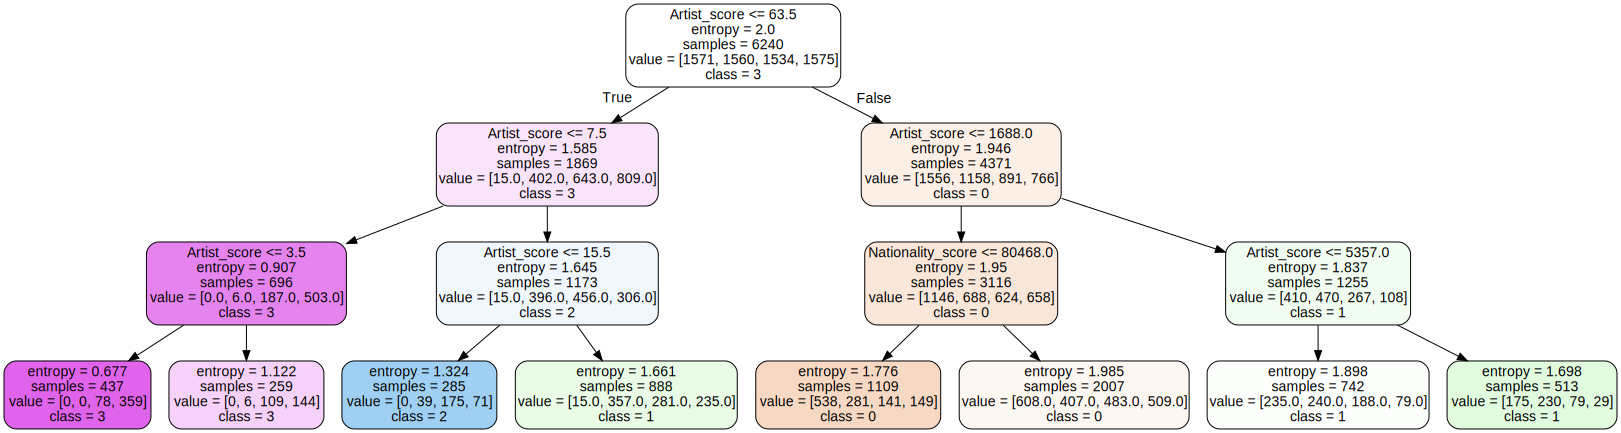

In [81]:
dot_data = export_graphviz(dt, out_file=None, 
    feature_names=x_train.columns,  
    class_names=['0', '1', '2', '3'],  
    filled=True, rounded=True,  
    special_characters=False)
graph = graphviz.Source(dot_data)
graph

In [82]:
column_names = x_train.columns
for i, column in enumerate(column_names):
    if dt.feature_importances_[i] > 0:
        print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))

Importance of feature Artist_score:, 0.932
Importance of feature Nationality_score:, 0.068


In [83]:
prediction_train = dt.predict(X=x_train)
prediction_test = dt.predict(X=x_test)
print('Classification accuracy on training set: {:.2f}'.format(accuracy_score(y_train,prediction_train)*100))
print('Classification accuracy on test set: {:.2f}'.format(accuracy_score(y_test,prediction_test)*100))

Classification accuracy on training set: 42.48
Classification accuracy on test set: 40.61


In [84]:
# Decision trees find best depth

In [85]:
# Random forrest?

In [86]:
# knn?

## Evaluation

In [87]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Create conf matrix for every model?

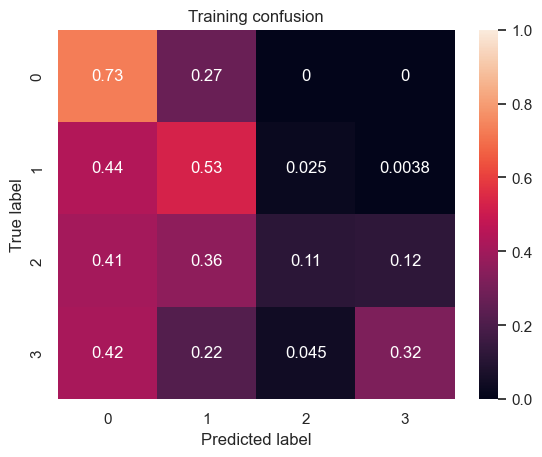

In [88]:
cm = confusion_matrix(y_train, prediction_train)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

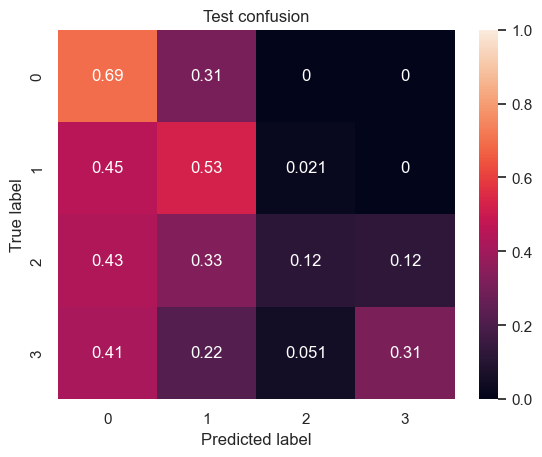

In [89]:
# Student needs to provide code similar to below
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Test confusion')

In [90]:
# Prec-Recall + F1 FOR DECISION TREES, different settings
print(precision_recall_fscore_support(y_test,prediction_test, average='macro'))
print(precision_recall_fscore_support(y_test,prediction_test, average='micro'))
print(precision_recall_fscore_support(y_test,prediction_test, average='weighted'))

(0.5139521182671265, 0.41219670666914254, 0.381066731710602, None)
(0.40614990390775146, 0.40614990390775146, 0.40614990390775146, None)
(0.5156292462151933, 0.40614990390775146, 0.37698357103421126, None)


How to measure "closeness" to correct class?

In [91]:
# cross validation / something